In [1]:
import pandas as pd

allowed_langs = ["en", "ru", "de", "fr", "uk-UA", "zh"]

In [2]:
messages = pd.read_json(
    path_or_buf="./oasst_ready/2023-04-12_oasst_ready.messages.jsonl.gz",
    lines=True,
)

In [3]:
messages[:3]

,message_id,user_id,created_date,text,role,lang,review_count,review_result,deleted,synthetic,emojis,labels,detoxify,message_tree_id,tree_state,parent_id,rank
0,6ab24d72-0181-4594-a9cd-deaf170242fb,c3fe8c76-fc30-4fa7-b7f8-c492f5967d18,2023-02-05T14:23:50.983374+00:00,Can you write a short introduction about the r...,prompter,en,3,1.0,False,False,"{'+1': 10, '_skip_reply': 1, '_skip_ranking': 4}","{'spam': {'value': 0.0, 'count': 3}, 'lang_mis...","{'toxicity': 0.00044308538781400006, 'severe_t...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,NaN,NaN
1,c8e83833-ecbc-44fe-b6db-735228c25a1c,2c96e467-66f0-4be7-9693-bda51356a424,2023-02-06T13:50:44.657083+00:00,"""Monopsony"" refers to a market structure where...",assistant,en,3,1.0,False,False,"{'+1': 3, '_skip_labeling': 1}","{'spam': {'value': 0.0, 'count': 3}, 'fails_ta...","{'toxicity': 0.000263965659542, 'severe_toxici...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,6ab24d72-0181-4594-a9cd-deaf170242fb,0.0
2,6708c47f-05c9-4346-b3d2-40b2bd24fde4,2c96e467-66f0-4be7-9693-bda51356a424,2023-02-06T18:48:49.391686+00:00,Now explain it to a dog,prompter,en,3,1.0,False,False,NaN,"{'spam': {'value': 0.0, 'count': 3}, 'lang_mis...","{'toxicity': 0.036484777927398, 'severe_toxici...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,c8e83833-ecbc-44fe-b6db-735228c25a1c,NaN


In [4]:
messages_dict = {}

for i in range(len(messages)):
    mess_id = messages.iloc[i]["message_id"]
    messages_dict[mess_id] = messages.iloc[i].to_dict()

In [5]:
trees = pd.read_json(
    path_or_buf="./oasst_ready/2023-04-12_oasst_ready.trees.jsonl.gz",
    lines=True,
)
trees
trees_dict = {}
for i in range(len(trees)):
    tree_id = trees["message_tree_id"][i]
    trees_dict[tree_id] = trees["prompt"][i]

In [ ]:
example_tree_id = list(trees_dict.keys())[3]

trees_dict[example_tree_id]

In [7]:
filtered_trees_dict = {}

for tree_id in trees_dict:
    tree_lang = trees_dict[tree_id]["lang"]
    # if tree_lang in ["ru"]:
    if tree_lang in ["en"]:
        filtered_trees_dict[tree_id] = trees_dict[tree_id]

In [8]:
len(filtered_trees_dict)

3670

In [11]:
filtered_example_id = list(filtered_trees_dict.keys())[31]
filtered_example = filtered_trees_dict[filtered_example_id]
# filtered_example

In [54]:
from collections.abc import Iterable


def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x


# https://codebeautify.org/python-formatter-beautifier - for debug
def get_all_threads(sample):
    # debug
    # initial_message = f"{sample['role'].upper()} {sample['text']} |"
    initial_message = f"{sample['message_id']} "

    def recursive_helper(node, current_path):
        if len(node["replies"]) == 0:
            if node["role"] == "assistant":
                # debug
                # current_path += f"\n|||||||||||||\n {node['role'].upper()} {node['text']}"
                current_path += f" {node['message_id']}"

            return current_path + " <END>"

        current_path += f" {node['message_id']}"
        paths = []
        for reply in node["replies"]:
            if node["labels"]["spam"]["value"] < 0.4:
                path = recursive_helper(reply, current_path)
                paths.append(path)
        return paths

    threads = []
    for reply in sample["replies"]:
        path = recursive_helper(reply, initial_message)
        threads.append(path)

    threads = flatten(threads)
    conversations = []
    for thread in threads:
        if "<END>" in thread:
            # debug
            # pprint.pprint(thread)
            # print(thread.split())
            conversation = thread.split()[:-1]
            conversations.append(conversation)

    return conversations


def ids_to_text(message_ids, messages):
    chat_history = []
    for mess_id in message_ids:
        text = messages[mess_id]["text"]
        chat_history.append(text)

    return chat_history

In [ ]:
# all_threads = get_all_threads(sample=trees["prompt"][10])
all_threads = get_all_threads(sample=filtered_example)
# all_threads

In [13]:
for thread in all_threads:
    messages_texts = ids_to_text(thread, messages_dict)
    print("\n---\n".join(messages_texts))
    print("-" * 100)

How can I find a girlfriend? I really don't hawe much to offer to others. At least I'm good in computers hardware and Linux. But not much girls have been interested in this kind of things. And it's probably impossible to find cute one.
---
Finding a girlfriend is not about having something to offer, but about being your authentic self and finding someone who appreciates and values you for who you are. Here are a few tips that might help:

Focus on your personal growth: Take some time to work on yourself and become the best version of yourself. This could mean developing your skills and interests, improving your health and wellness, and building your confidence.

Meet new people: Get out of your comfort zone and try to meet new people. You can join clubs or groups that align with your interests, attend events and parties, or simply strike up conversations with people you meet in your daily life.

Be open-minded: Don't limit yourself to just looking for someone who is interested in the s

### prepare for filter export


In [15]:
import pandas as pd

# export_name = "./datasets/filtered_datasets/oasst/ru/oasst_ru_v1.csv"
# export_name = "./filtered/oasst/en/oasst_en_v1.csv"
export_name = ""
messages_count = 0

result_dataset = []

for filtered_id in filtered_trees_dict.keys():
    filtered_tree = filtered_trees_dict[filtered_id]
    filtered_threads_ids = get_all_threads(sample=filtered_tree)
    messages_count += len(filtered_threads_ids)
    for thread in filtered_threads_ids:
        thread_str = " ".join(thread)
        filtered_threads_mess = ids_to_text(thread, messages_dict)
        filtered_threads = "\n=======\n".join(filtered_threads_mess)
        # print(filtered_threads)
        result_dataset.append(
            {
                "conversation": filtered_threads,
                "conversation_ids": thread_str,
            },
        )
        # print("-" * 100)
    # print("-" * 100)
    # print("-" * 100)
    # print("-" * 100)
    # break
# messages_count
pd.DataFrame(data=result_dataset).to_csv(export_name, index=False)

### use labeled dataset


In [55]:
import pandas as pd

# dataset_path = "./filtered/ru/oasst_ru_v1_labeled - oasst_ru_v1.csv"
dataset_path = "./filtered/en/oasst_en_v1_labeled - oasst_en_v1.csv"
labeled_dataset = pd.read_csv(dataset_path)
# labeled_dataset = labeled_dataset[labeled_dataset["ok/trash"] == "ok"]
conversation_ids = labeled_dataset["conversation_ids"].tolist()
conversation_ids[:3]

['6ab24d72-0181-4594-a9cd-deaf170242fb c8e83833-ecbc-44fe-b6db-735228c25a1c',
 '6ab24d72-0181-4594-a9cd-deaf170242fb 343ee2d4-87ae-41fd-a768-bdd65959dc4a',
 '6ab24d72-0181-4594-a9cd-deaf170242fb 636dd191-50df-4894-ba9a-cd7f00767258 ac94bfcf-7f25-4084-8755-dde345ac2323 73d6f715-3787-409c-81e4-fde0e5ef60cd']

In [56]:
messages = pd.read_json(
    path_or_buf="./oasst_ready/2023-04-12_oasst_ready.messages.jsonl.gz",
    lines=True,
)

messages_dict = {}

for i in range(len(messages)):
    mess_id = messages.iloc[i]["message_id"]
    messages_dict[mess_id] = messages.iloc[i].to_dict()

In [57]:
import numpy as np

huggingface_dataset = []

for i in range(len(labeled_dataset)):
    conversation_id = labeled_dataset["conversation_ids"].iloc[i]
    ok_trash = labeled_dataset["ok/trash"].iloc[i]
    if not ok_trash is np.nan:
        ids = conversation_id.split()
        mess = ids_to_text(ids, messages_dict)
        # print(ok_trash, mess)
        item = {"conversation_ids": ids, "conversation_text": mess, "status": ok_trash}
        huggingface_dataset.append(item)
    # break

In [39]:
huggingface_dataset[0]

{'conversation_ids': ['6ab24d72-0181-4594-a9cd-deaf170242fb',
  'c8e83833-ecbc-44fe-b6db-735228c25a1c'],
 'conversation_text': ['Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.',
  '"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 20

In [40]:
from datasets import Dataset

dataset = Dataset.from_list(huggingface_dataset)
# dataset = dataset.filter(lambda x: x['status'] == 'ok')
# dataset[0]
# dataset.push_to_hub("dim/oasst_ru",)
dataset.push_to_hub(
    "dim/oasst_en",
)

Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


### show distribution


/home/kosenko/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset parquet (/home/kosenko/.cache/huggingface/datasets/dim___parquet/dim--oasst_ru-5a8e133344e792f9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 37.09it/s]


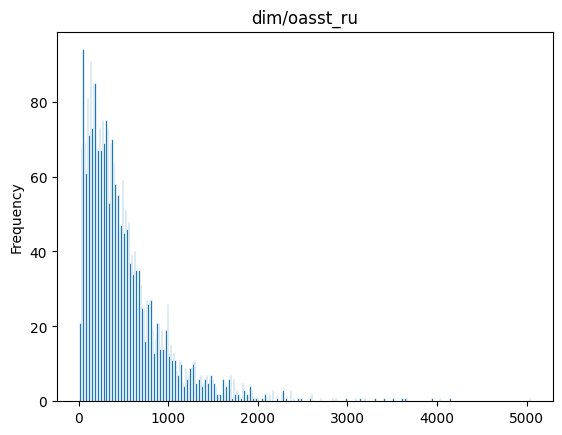

Found cached dataset parquet (/home/kosenko/.cache/huggingface/datasets/dim___parquet/dim--oasst_en-10d24d77c58fc114/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 45.11it/s]


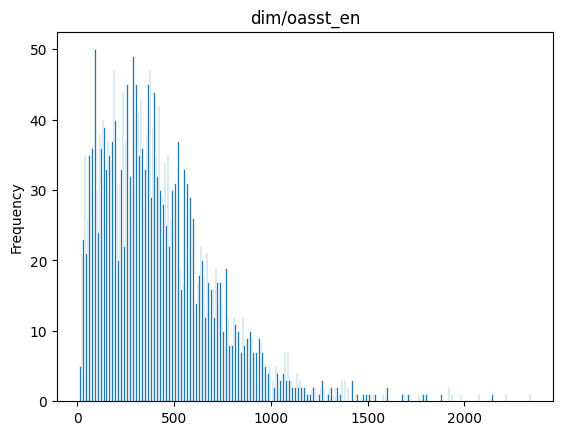

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
from verbalist.datasets.utils import visualize_hist

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
dataset_names = [
    "dim/oasst_ru",
    "dim/oasst_en",
]

for dataset_name in dataset_names:
    dataset = load_dataset(dataset_name)
    dataset = dataset["train"]
    lengths = []

    for item in dataset:
        all_conv = "\n===========\n".join(item["conversation_text"])
        length = len(tokenizer(all_conv)["input_ids"])
        lengths.append(length)
        # print(all_conv)
    visualize_hist(lengths, dataset_name)